# Solar Panel Return on Investment
This notebook calculates the payback period and Return on Investment (ROI) of a ground mount solar panel array facing southwest in Ann Arbor, MI.

In [1]:
import json

# Open JSON file containing electricity rates
f = open('electricity_rates.json')
# Returns JSON object as a dictionary
elctr_rates = json.load(f) 
# Close file
f.close()

# Create class to calculate electricity rates purchase and sell back rates
# DTE Residential Electric Pricing Options:
# https://newlook.dteenergy.com/wps/wcm/connect/23195474-a4d1-4d38-aa30-a4426fd3336b/WholeHouseRateOptions.pdf?MOD=AJPERES

class Rate:
    def __init__(self, name, elctr_rates):
        pscr = elctr_rates['time_invariant_costs'][0]['pscr']
        self.distr = elctr_rates['time_invariant_costs'][0]['distr']

        for rate in elctr_rates['time_varying_costs']:
            if rate['name'] == name:
                self.name = rate['name']              
                if name == 'D1_8':
                    self.peak = rate['peak_hours']
                    self.mdpeak = rate['mdpeak_hours']
                    self.peak_sell = rate['peak_cap'] + rate['peak_ncp'] + pscr
                    self.midpk_sell = rate['midpk_cap'] + rate['midpk_ncp'] + pscr
                    self.offpk_sell = rate['offpk_cap'] + rate['offpk_ncp'] + pscr
                    self.peak_buy = self.peak_sell + self.distr
                    self.midpk_buy = self.midpk_sell + self.distr  
                    self.offpk_buy = self.offpk_sell + self.distr
                    # calc price over 24 period
                    self.sell = []
                    for hour in range(0,24):
                        if (hour >= self.peak[0]) and (hour < self.peak[1]):
                            # on peak
                            self.sell.append(self.peak_sell)
                        elif ((hour >= self.mdpeak[0][0]) and (hour < self.mdpeak[0][1]) or (hour >= self.mdpeak[1][0]) and (hour < self.mdpeak[1][1])):
                            # mid peak
                            self.sell.append(self.midpk_sell)
                        else:
                            # off peak
                            self.sell.append(self.offpk_sell)
                    self.buy = [x + self.distr for x in self.sell]
                    # Print purchase rates
                    if False:
                        print(self.name + " Purchase Rates")
                        print("\tPeak: %.3f" % self.peak_buy)
                        print("\tMid Peak: %.3f" % self.midpk_buy)
                        print("\tOff Peak: %.3f" % self.offpk_buy + "\n")
                if name == "D1_11" or name == "D1_2":
                    self.smmr = rate['smmr_mnths']
                    self.peak = rate['peak_hours']
                    # Calculate cost to purchase and sell back electricity in the summer and
                    # winter during on-peak and off-peak hours
                    self.smmr_peak_sell = rate['smmr_peak_cap'] + rate['smmr_peak_ncp'] + pscr
                    self.smmr_offpk_sell = rate['smmr_offpk_cap'] + rate['smmr_offpk_ncp'] + pscr
                    self.wntr_peak_sell = rate['wntr_peak_cap'] + rate['wntr_peak_ncp'] + pscr
                    self.wntr_offpk_sell = rate['wntr_offpk_cap'] + rate['wntr_offpk_ncp'] + pscr
                    self.smmr_peak_buy = self.smmr_peak_sell + self.distr
                    self.smmr_offpk_buy = self.smmr_offpk_sell + self.distr
                    self.wntr_peak_buy = self.wntr_peak_sell + self.distr
                    self.wntr_offpk_buy = self.wntr_offpk_sell + self.distr
                    # calc price over 24 period
                    self.smmr_sell = []
                    self.wntr_sell = []
                    for month in range(0,12):
                        if (month < self.smmr[0]) or (month > self.smmr[1]):
                            # winter
                            for hour in range(0,24):
                                if (hour < self.peak[0]) or (hour > self.peak[1]):
                                    # off peak
                                    self.wntr_sell.append(self.wntr_offpk_sell)
                                else:
                                    # on peak
                                    self.wntr_sell.append(self.wntr_peak_sell)
                        else:
                            # summer
                            for hour in range(0,24):
                                if (hour < self.peak[0]) or (hour > self.peak[1]):
                                    # off peak
                                    self.smmr_sell.append(self.smmr_offpk_sell)
                                else:
                                    # on peak
                                    self.smmr_sell.append(self.smmr_peak_sell)
                    self.smmr_buy = [x + self.distr for x in self.smmr_sell]
                    self.wntr_buy = [x + self.distr for x in self.wntr_sell]
                    # Print purchase rates
                    if False:
                        print(self.name + " Purchase Rates")
                        print("\tSummer Peak: %.3f" % self.smmr_peak_buy)
                        print("\tSummer OffP: %.3f" % self.smmr_offpk_buy)
                        print("\tWinter Peak: %.3f" % self.wntr_peak_buy)
                        print("\tWinter OffP: %.3f" % self.wntr_offpk_buy + "\n")
   
# Define electricity rates
D1_11 = Rate("D1_11", elctr_rates)
D1_2 = Rate("D1_2", elctr_rates)
D1_8 = Rate("D1_8", elctr_rates)

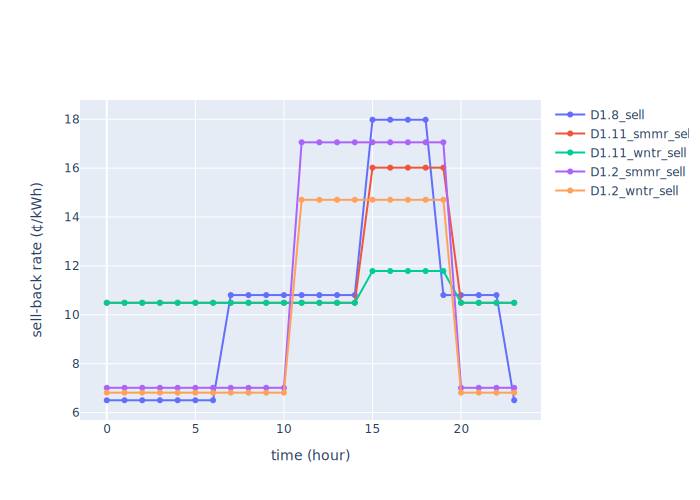

In [2]:
# plot rates

import plotly.graph_objects as go
import numpy as np
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=np.linspace(0, 23, 24),
        y=D1_8.sell,
        name="D1.8_sell",
        mode="lines+markers",
    )
)
fig.add_trace(
    go.Scatter(
        x=np.linspace(0, 23, 24),
        y=D1_11.smmr_sell,
        name="D1.11_smmr_sell",
        mode="lines+markers",
    )
)
fig.add_trace(
    go.Scatter(
        x=np.linspace(0, 23, 24),
        y=D1_11.wntr_sell,
        name="D1.11_wntr_sell",
        mode="lines+markers",
    )
)
fig.add_trace(
    go.Scatter(
        x=np.linspace(0, 23, 24),
        y=D1_2.smmr_sell,
        name="D1.2_smmr_sell",
        mode="lines+markers",
    )
)
fig.add_trace(
    go.Scatter(
        x=np.linspace(0, 23, 24),
        y=D1_2.wntr_sell,
        name="D1.2_wntr_sell",
        mode="lines+markers",
    )
)
# Update axis labels
fig.update_xaxes(title_text="time (hour)")

# fig.update_yaxes
fig.update_yaxes(title_text="sell-back rate (¢/kWh)")

# plot output
fig.show("svg")


In [3]:
fig2 = go.Figure()
fig2.add_trace(
    go.Scatter(
        x=np.linspace(0, 23, 24),
        y=D1_8.buy,
        name="D1.8_buy",
        mode="lines+markers",
    )
)
fig2.add_trace(
    go.Scatter(
        x=np.linspace(0, 23, 24),
        y=D1_11.smmr_sell,
        name="D1.11_smmr_buy",
        mode="lines+markers",
    )
)
fig2.add_trace(
    go.Scatter(
        x=np.linspace(0, 23, 24),
        y=D1_11.wntr_sell,
        name="D1.11_wntr_buy",
        mode="lines+markers",
    )
)
fig2.add_trace(
    go.Scatter(
        x=np.linspace(0, 23, 24),
        y=D1_2.smmr_sell,
        name="D1.2_smmr_buy",
        mode="lines+markers",
    )
)
fig2.add_trace(
    go.Scatter(
        x=np.linspace(0, 23, 24),
        y=D1_2.wntr_sell,
        name="D1.2_wntr_buy",
        mode="lines+markers",
    )
)
# Update axis labels
fig2.update_xaxes(title_text="time (hour)")

# fig.update_yaxes
fig2.update_yaxes(title_text="purchase rate (¢/kWh)")

In [4]:
# Open JSON file containing solar array information
f = open('solar_params.json')
# Returns JSON object as a dictionary
solar_info = json.load(f) 
# Close file
f.close()